In [1]:
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [2]:
psf_directory = '/data/scratch/bariskurtkaya/dataset/PSF_SAMPLES/*'
psf_dirs = glob(psf_directory)
gen_psf = fits.open(psf_dirs[0])[1].data

fits.open(psf_dirs[0])[1].header


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  640                                                  
NAXIS2  =                  640                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 2.98203115618662E-06 / Weighted mean wavelength in meters             
DIFFLMT =  0.08833256135803114 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    1 / These data are rebinned to detector pixels     
DET_SAMP=                    2 / Oversampling factor for MFT to detector plane  
PIXELSCL=                0.0

1.0


(-0.5, 319.5, 319.5, -0.5)

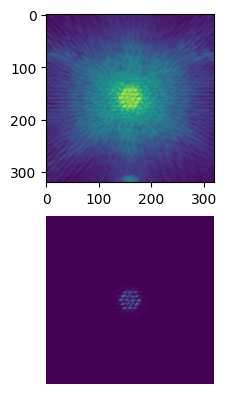

In [21]:
crop_psf = gen_psf[
    gen_psf.shape[0]//2-160:gen_psf.shape[0]//2 +160, 
    gen_psf.shape[1]//2 -160:gen_psf.shape[1]//2+160
    ]

crop_psf = (crop_psf - np.min(crop_psf) )/ (np.max(crop_psf)-np.min(crop_psf))

plt.subplot(2, 1, 1)
plt.imshow(np.arcsinh((2**16)*crop_psf))

plt.subplot(2, 1, 2)
plt.imshow(crop_psf)

plt.axis('off')

In [8]:
np.sqrt(0.003918172030450555)

0.06259530358142339

In [23]:
real_psf_dir = '/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/mastDownload/JWST/*psfstack*'
real_psfs = glob(real_psf_dir)

real_psf = fits.open(real_psfs[1])[1].data[0]

fits.open(real_psfs[1])[1].header


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  320                                                  
NAXIS2  =                  320                                                  
NAXIS3  =                  466                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
MJD-BEG =    59789.99725859676 / [d] exposure start time in MJD                 
MJD-AVG =    59789.99822370231 / [d] exposure mid-point in MJD                  
MJD-END =    59789.99918880787 / [d] exposure end time in MJD                   
TDB-BEG =    59790.002266567

(-0.5, 319.5, 319.5, -0.5)

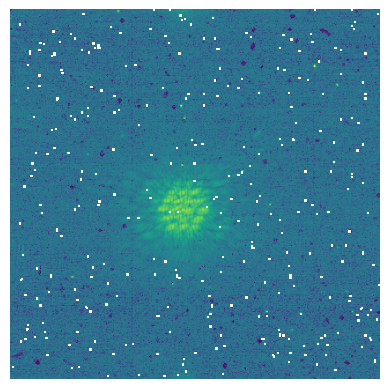

In [10]:
plt.imshow(np.arcsinh(real_psf))
plt.axis('off')

In [168]:
import numpy as np

def deconvolve_2d(img, kernel):
    fourier_img = np.fft.fft2(img)
    fourier_kernel = np.fft.fft2(kernel)
    fourier_kernel = np.fft.fftshift(fourier_kernel)
    fourier_img = np.fft.fftshift(fourier_img)
    deconvolved = np.divide(fourier_img, fourier_kernel)
    deconvolved = np.fft.ifftshift(deconvolved)
    deconvolved = np.fft.ifft2(deconvolved)
    deconvolved = np.abs(deconvolved)
    return deconvolved

In [203]:
crop_size = 40

In [204]:
psf = gen_psf[
    int(gen_psf.shape[0]/2)-crop_size:int(gen_psf.shape[0]/2)+crop_size,
    int(gen_psf.shape[1]/2)-crop_size:int(gen_psf.shape[1]/2)+crop_size
]

In [205]:
real_psf_cropped = np.nan_to_num(real_psf[
    int(real_psf.shape[0]/2)-crop_size:int(real_psf.shape[0]/2)+crop_size,
    int(real_psf.shape[1]/2)-crop_size:int(real_psf.shape[1]/2)+crop_size
])

In [206]:
star_deconv = deconvolve_2d(real_psf_cropped, psf)

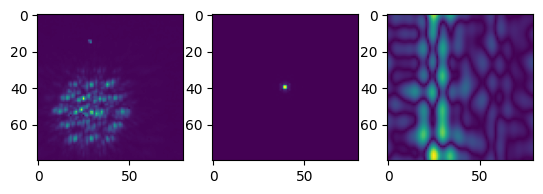

In [207]:
f, axes = plt.subplots(1,3)

axes[0].imshow(real_psf_cropped)
axes[1].imshow(psf)
axes[2].imshow(np.real(star_deconv))

In [215]:
from scipy.signal import convolve2d

In [216]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [228]:
synth = np.zeros((crop_size, crop_size))

synth[create_circular_mask(crop_size, crop_size, radius=5)] = 1

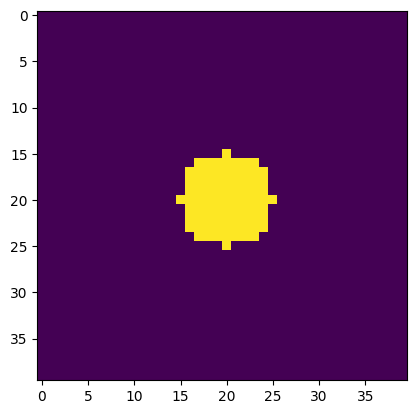

In [229]:
plt.imshow(synth)

In [230]:
convolved = convolve2d(synth, psf, mode='same')

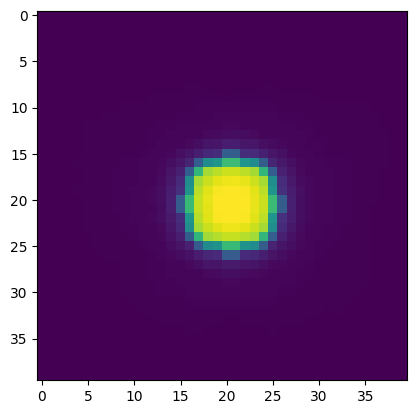

In [231]:
plt.imshow(convolved)